In [1]:
from NSynthDataSet_RawAudio import NSynthDataSet_RawAudio
from transformers import GTransformer

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import RandomSampler

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa

import random, sys, math, gzip, os
from tqdm import tqdm
from IPython.display import Audio 

In [50]:
### Constants 

sample_rate = 16000

batch_size = 16
lr = 0.001
lr_warmup = 5000
epochs = 100

sample_length = 512 # For context
num_heads = 8 # Number of chunks for 'parallel/ensemble' computation
depth = 12 # Number of transformer layers
num_tokens = 255 #Size of the dictionary
quantization_channels = 255

sample_index = 4
use_temperature = True
temperature = 0.4

In [40]:
model = GTransformer(seq_length=sample_length, heads=num_heads, depth=depth, num_tokens=num_tokens)
model = model.cuda()
model = model.float()

opt = torch.optim.Adam(lr=lr, params=model.parameters())
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (lr_warmup / batch_size), 1.0))
loss = torch.nn.NLLLoss(reduction='mean')

In [41]:
base_data_dir = '/home/purnima/appdir/Github/DATA/NSynth/'
labels_dir = '/home/purnima/appdir/Github/DATA/NSynth'

validate_data_dir = os.path.join(base_data_dir,'nsynth-valid','audio')
labels_validate_dir = os.path.join(labels_dir,'nsynth-valid', 'examples.json')

validate_ds = NSynthDataSet_RawAudio(meta_data_file=labels_validate_dir, audio_dir=validate_data_dir, sr=sample_rate)
validate_loader = torch.utils.data.DataLoader(validate_ds, batch_size=batch_size, shuffle=False)

(892, 13)


## Sampling
Sampling is done as follows -  
1. Select an input from the dataloader (update sample_index to any value from 0 to 15). Shape will be `1 X sample_length` or `1 X 512`
2. Generate the output from the model. Shape will be `1 X 512 X 256`
3. Retrieve the last sample from the 512 sample_length dimension `sample_data = sample_data[0, -1, :]` (argmax or temperature sampling (-- I need to understand this more--)  
4. Append this sample to the input (from step 1). Both input and this new sample are between 0 - 255. Use this as the new input and repeat from Step 1 for as long as you want (here we are iterating through the steps 256 times to generate 256 new samples).
5. Convert this 512 + 256 new samples to waveform using mu_expand from librosa.

In [63]:
def sample():
    iterator = iter(validate_loader)
    orig_test_data, _ = iterator.next()

    test_data = orig_test_data[sample_index].view(1,-1)
    orig_waveform = mulawDecode(test_data.view(-1).cpu() * quantization_channels)
    test_data = test_data.cuda()
    test_data_ = test_data.clone().cuda()
    with torch.no_grad():
#         print(test_data)
        for ind in range(int(sample_length/2)):
            test_data = test_data.float()
            sample_data = model(test_data) 
#             print(sample_data.shape)
#             print(sample_data.argmax())
            if use_temperature:
                p = F.softmax(sample_data / temperature, dim=0)
                cd = dist.Categorical(p)
                sample_data = cd.sample()
#                 sample_data = sample_data[:,-1:]
#                 print(sample_data.shape)
            else:
                sample_data = sample_data.argmax() 
            
            sample_data = (sample_data - 127)/quantization_channels
            sample_data = sample_data.view(1,-1)
            test_data_ = torch.cat([test_data_, sample_data], dim=1)
            test_data = test_data_[:,:sample_length].view(1,-1)
    
    test_data_ = test_data_.view(-1).cpu()
    waveform = mulawDecode(test_data_ * quantization_channels)
    
    return waveform, orig_waveform

In [64]:
def load_model(model, opt, model_location):
    checkpoint = torch.load(model_location)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    epoch = checkpoint['epoch']
    return model, opt, loss, epoch

def mulawDecode(output):
    output = output.numpy()
    waveform = librosa.mu_expand(output, quantize=True)
    return waveform

In [65]:
model, opt, loss, epoch = load_model(model, opt, 'checkpoint/attention-50.pt')
print('Model Loaded')
new_sample, orig_seed = sample()

Model Loaded
tensor([0.4745], device='cuda:0')
tensor([0.1137], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([-0.1176], device='cuda:0')
tensor([-0.2863], device='cuda:0')
tensor([0.1098], device='cuda:0')
tensor([0.2157], device='cuda:0')
tensor([0.3804], device='cuda:0')
tensor([0.3176], device='cuda:0')
tensor([0.3647], device='cuda:0')
tensor([-0.0039], device='cuda:0')
tensor([0.0431], device='cuda:0')
tensor([-0.4078], device='cuda:0')
tensor([-0.0588], device='cuda:0')
tensor([-0.0784], device='cuda:0')
tensor([-0.3922], device='cuda:0')
tensor([0.3020], device='cuda:0')
tensor([-0.3412], device='cuda:0')
tensor([0.3882], device='cuda:0')
tensor([0.3059], device='cuda:0')
tensor([0.0549], device='cuda:0')
tensor([0.4392], device='cuda:0')
tensor([-0.1843], device='cuda:0')
tensor([0.2431], device='cuda:0')
tensor([0.1765], device='cuda:0')
tensor([0.1529], device='cuda:0')
tensor([-0.3765], device='cuda:0')
tensor([0.1843], device='cuda:0')
tensor([-0.4980], device='cud

Original seed


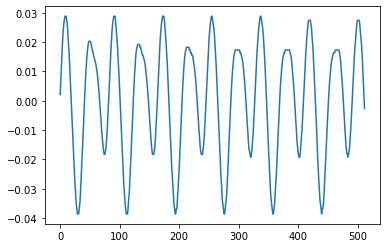

In [66]:
print('Original seed')
plt.plot(orig_seed)
Audio(orig_seed, rate=sample_rate)

New sample appended to original seed


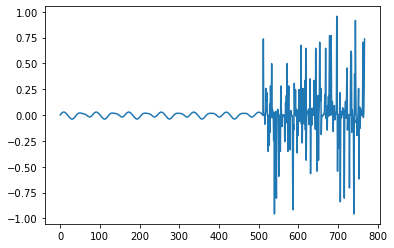

In [67]:
print('New sample appended to original seed') #First 512 samples are original seed
plt.plot(new_sample)
Audio(new_sample, rate=sample_rate)